In [2]:
import numpy as np
from math import factorial
from sech_pulse import sech
from plse_width import pulse_width
import laser_comp_f as comp
import matplotlib.pyplot as plt
from laser_30s import coupler,amplifier,outcoupler,fiber,combiner,amplifier2
#from laser_comp_exp_fft import amplifier2
#%load_ext Cython

Parameters

In [3]:
L=400#   %ps
nt=2**12# %number of points in time window
dt=L/nt#  % ps 
t2 = np.linspace(-L/2,L/2-1,nt) 
t = t2.T#  time vector ps
#w = 2*pi/L*[0:nt/2-1 -nt/2:-1]' w move omega
omega = 2*(np.pi/L)*np.array([np.linspace(0,nt/2-1,nt/2), np.linspace(-nt/2,-1,nt/2)])# frequency grid
omega = np.reshape(omega,(np.product(omega.shape),))
c=2.99792458e-7# km/ps
lambda0=1080e-12# %km 
lambdap=980e-12
nus=c/lambda0#THz
nup=c/lambdap
h=6.63e-10#pJ ps

#%#AMPLIFIER PARAMETERS%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%c1 = amplifier(c0,w,halfstepa,dt,dza,nza,gammaa,g0,deltawg,Penergy);
#% la=0.3e-3; %km

La1=5.3e-3# %km   % 1m
La2=5.0e-3#
dza=0.001e-3# % km %0.0001
nza1=int(La1//dza)
nza2=int(La2//dza)

alphadbperkma=0# %db/km
alphaa=np.log(10**(alphadbperkma/10))#%1/km
betaa=np.array([0,0,23])# %ps^2/km%+++++++++++++++++++++++++DISPERSION
gammaa=4.7# %1/W/km

bandwidthfwhm=50e-12#%1/km++++++++++++++++++++++++++++++GAIN BANDWIDTH 
bandwidth=bandwidthfwhm*(2**0.5)#%% 1/km 
#%bandwidth=40e-12;
deltawg=2*np.pi*c*bandwidth/((lambda0)**2)# % THz rad
halfstepa = -alphaa/2
for ii in range(len(betaa)):
    halfstepa = halfstepa + 1j*betaa[ii]*(omega)**ii/factorial(ii)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%Gain parameters
Psatp=4.9
Psats=55e-3# %mW
alpha1p=0.115e3# %1/km
alpha1s=0.062e3#
Ndop=1.9e34# %km^(-3)
sigmaap=6.35e-31#  %km^2
sigmaep=2.0e-32# 
sigmaas=1.5e-33# 
sigmaes=2.2e-31# 
tau=0.84e9# %ps
A=5.0e-17# %km^2
Gammap=0.2
Gammas=0.82
alpha2p=0.003e3# %km^(-1)
alpha2s=0.005e3#
alphap=alpha1p+alpha2p
alphas=alpha1s+alpha2s
mu=(sigmaap/sigmaas)*(sigmaas+sigmaes)/(sigmaep+sigmaap)

Pp01=2.6# %W
Pp02=1.6#
PpL1=Pp01*np.exp(-alphap*La1)
PpL2=Pp02*np.exp(-alphap*La2)

#%%%% PASSIVE FIBRE
Lf1=12.4e-3# %km
Lf2=2.8e-3
dzf=0.001e-3# % km
nzf1 = int(Lf1//dzf)
nzf2 = int(Lf2//dzf)
alphadbperkmf=0# %db/km
alphaf=np.log(10**(alphadbperkmf/10))#%1/km
betaf = np.array([0,0,23])# %ps^2/km%+++++++++++++++++++++++++DISPERSION
gammaf=4.7# %1/W/km
halfstepf = -alphaf/2;
for ii in range(len(betaf)):
    halfstepf = halfstepf + 1j*betaf[ii]*(omega)**ii/factorial(ii)
    
#%%%% NOLM COUPLER
alpha=0.6

#%%%OUTPUTCOUPLER
beta=0.7#%reflectivity

#% /////INPUT PULSE////////////////%
P0=60# %W
Tfwhm=10# %ps
input_pulse=sech(t,0)# not sure about this moment



In [4]:
print('nza1',nza1,'nza2',nza2,'nzf1',nzf1,'nzf2',nzf2)

nza1 5300 nza2 5000 nzf1 12400 nzf2 2800


In [4]:
energy = sum(np.abs(input_pulse)**2)*L
u = np.abs(input_pulse)**2
fw = pulse_width(u,dt) #possibly pulse width must be rewritten 

Preparation for main loop

In [5]:
np.absolute(np.array([1+1j,1,1,1,1]))

array([ 1.41421356,  1.        ,  1.        ,  1.        ,  1.        ])

In [6]:
1e12/100

10000000000.0

In [17]:
def NALM(roundtrip,Lf1,input_pulse,step,Pp01,Pp02):
    PpL1=Pp01*np.exp(-alphap*La1)
    PpL2=Pp02*np.exp(-alphap*La2)

    nzf1 = int(Lf1//dzf)
    c0 = input_pulse
    #energy = []
    #peak = []
    #width = []
    for i in range(roundtrip):

        c1,c2 = coupler(c0,alpha)

        c3 = amplifier(c1,omega,halfstepa,dt,dza,nza1,gammaa,deltawg,Pp01,Psatp,Psats,alpha1p, alpha1s,alphap,alphas,mu,L)
        c4 = fiber(c3,halfstepf,dzf,nzf1,gammaf) 
        c5 = amplifier2(c4,omega,halfstepa,dt,dza,nza2,gammaa,deltawg,PpL2,Psatp,Psats,alpha1p, alpha1s, alphap,alphas,mu,L)

        c6 = amplifier(c2,omega,halfstepa,dt,dza,nza2,gammaa,deltawg,Pp02,Psatp,Psats,alpha1p, alpha1s, alphap,alphas,mu,L)
        c7 = fiber(c6,halfstepf,dzf,nzf1,gammaf) 
        c8 = amplifier2(c7,omega,halfstepa,dt,dza,nza1,gammaa,deltawg,PpL1,Psatp,Psats,alpha1p,alpha1s,alphap,alphas,mu,L)

        c9 = combiner(c5,c8,alpha)
        c10 = fiber(c9,halfstepf,dzf,nzf2,gammaf) 
        c11,c12 = outcoupler(c10,1-beta)
        #energy.append(sum(np.abs(c12)**2)*dt)
        #peak.append(max(np.abs(c12)**2))
        #width.append(pulse_width(c12,dt))

    #u(:,i+1) =abs(c12).^2;
    #fw(1,i+1)=fwhm(t,abs(c12)**2;
        c0=c11
       
        if i%step == 0 and i!=0 :
            f , (x1,x2) = plt.subplots(2,1)
            x1.plot(t,abs(c12)**2)
            x2.plot(1e12*(lambda0+(lambda0**2/(2*np.pi*c))*2*np.pi*np.fft.fftfreq(c12.size,dt)),np.abs(np.fft.ifft(c12)*(nt*dt)/np.sqrt(2*np.pi)))#must be removed
            x2.set_title('Spectrum')
            x1.set_title('Shape')
            pic_name = 'C:/Users/ilyag/Pictures/MatLab/files/energy_1m/{0}_{1}_energy1_{2}_energy2_{3}.png'.format(i,Lf1,Pp01,Pp02)
            f.savefig(pic_name)
            f.clf()
            plt.close(f)
    return c12

In [20]:
NALM(20,Lf1,input_pulse,19,4,4)

array([ -2.84401346e-05 +8.08375769e-06j,
        -1.93155356e-04 +2.93845759e-04j,
         6.48116867e-05 -7.76310668e-05j, ...,
        -1.93139669e-04 +2.85424596e-04j,
        -8.12854526e-06 +6.25322961e-05j,   1.96882870e-04 -2.97621505e-04j])

In [ ]:
#Lndf = np.linspace(10e-3,15e-3,25)
Diff = np.linspace(9.5,9.9,10)
NDF = np.array([NALM(50,5e-3,input_pulse,48,diff, diff) for diff in Diff])


In [12]:
Energy = np.array([np.sum(np.abs(n)**2)*dt for n in NDF])


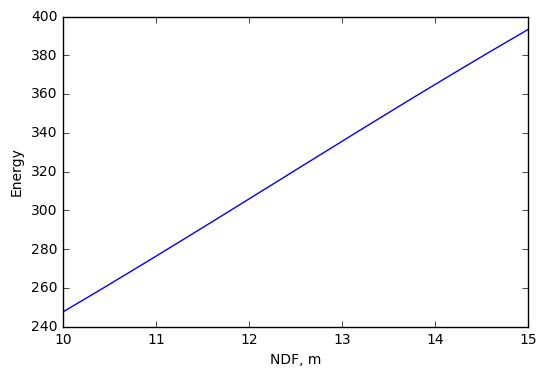

In [16]:
plt.plot(Lndf*1000,Energy)
plt.xlabel('NDF, m')
plt.ylabel('Energy')
plt.savefig('energyNDF.png')
plt.show()

In [68]:
width = np.array([pulse_width(np.abs(n)**2,dt) for n in NDF])

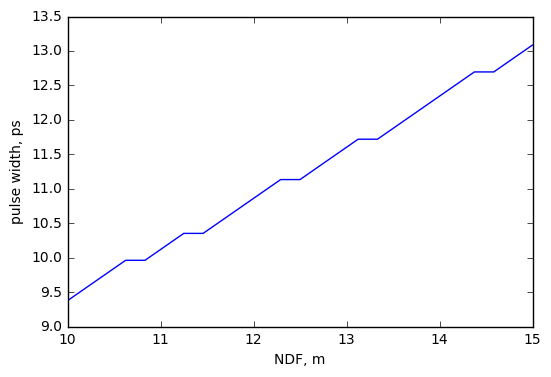

In [69]:
plt.plot(Lndf*1000,width)
plt.xlabel('NDF, m')
plt.ylabel('pulse width, ps')
plt.savefig('widthNDF.png')
plt.show()

In [70]:
NDF_abs = np.abs(NDF)

In [72]:
peak = np.array([max(n*n) for n in NDF_abs])

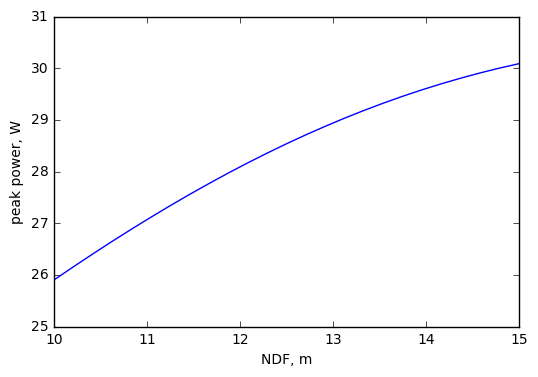

In [74]:
plt.plot(Lndf*1000,peak)
plt.xlabel('NDF, m')
plt.ylabel('peak power, W')
plt.savefig('peakNDF.png')
plt.show()

In [82]:
type(input_pulse)

numpy.ndarray

In [11]:
roundtrip = 60
c0 = input_pulse
energy = []
peak = []
width = []
for i in range(roundtrip):

    c1,c2 = comp.coupler(c0,alpha)

    c3 = comp.amplifier(c1,omega,halfstepa,dt,dza,nza1,gammaa,deltawg,Pp01,Psatp,Psats,alpha1p, alpha1s,alphap,alphas,mu,L)
    c4 = comp.fiber(c3,halfstepf,dzf,nzf1,gammaf) 
    c5 = comp.amplifier2(c4,omega,halfstepa,dt,dza,nza2,gammaa,deltawg,PpL2,Psatp,Psats,alpha1p, alpha1s, alphap,alphas,mu,L)

    c6 = comp.amplifier(c2,omega,halfstepa,dt,dza,nza2,gammaa,deltawg,Pp02,Psatp,Psats,alpha1p, alpha1s, alphap,alphas,mu,L)
    c7 = comp.fiber(c6,halfstepf,dzf,nzf1,gammaf) 
    c8 = comp.amplifier2(c7,omega,halfstepa,dt,dza,nza1,gammaa,deltawg,PpL1,Psatp,Psats,alpha1p,alpha1s,alphap,alphas,mu,L)

    c9 = comp.combiner(c5,c8,alpha)
    c10 = comp.fiber(c9,halfstepf,dzf,nzf2,gammaf) 
    c11,c12 = comp.outcoupler(c10,1-beta)
    energy.append(sum(np.abs(c12)**2)*dt)
    peak.append(max(np.abs(c12)**2))
    width.append(pulse_width(c12,dt))

    #u(:,i+1) =abs(c12).^2;
    #fw(1,i+1)=fwhm(t,abs(c12)**2;
    c0=c11
       
    if i%11 == 0:
        f , (x1,x2) = plt.subplots(2,1)
        x1.plot(t,abs(c12)**2)
        x2.plot(1e12*(lambda0+(lambda0**2/(2*np.pi*c))*2*np.pi*np.fft.fftfreq(c12.size,dt)),np.abs(np.fft.ifft(c12)*(nt*dt)/np.sqrt(2*np.pi)))#must be removed
        x2.set_title('Spectrum')
        x1.set_title('Shape')
        pic_name = 'C:/Users/ilyag/Pictures/MatLab/files/results/{0}.png'.format(i)
        f.savefig(pic_name)
        f.clf()
        plt.close(f)
    
    
